Hunter Bennett | Glass Lab | Brain Aging Project | 19 Feb 2021

This notebook uses the peak files generated in the prior notebook to call motifs. As mentioned in the lead-in to that notebook we are a little unsure of what peak sets to use for our analyses, but right now there are three possible methods:

1. Call motifs across 1000bp broad peaks.
2. Call motifs on HOMER identified nucleosome free regions.
3. Call motifs on HisTrader identified nucleosome free regions.

So we will try each of these in this notebook and see what each yield!

This notebook also plots the results of knownMotif analysis as a heatmap to make comparisons across analyses easier.

In [4]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

In [5]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/PU1/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_PU1_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Check how many peaks are in the histrader files

In [3]:
!wc -l ./4month_vs_25month/bed_files/*

  511 ./4month_vs_25month/bed_files/00_pu1_4month_union_act_peaks.bed
  775 ./4month_vs_25month/bed_files/01_pu1_25month_union_act_peaks.bed
 1286 total


In [6]:
!wc -l ./4month_vs_25month/histrader/0*nfr.bed

  6043 ./4month_vs_25month/histrader/00_pu1_4month_act_histrader.nfr.bed
  6149 ./4month_vs_25month/histrader/01_pu1_25month_act_histrader.nfr.bed
 12192 total


# Call motifs

In [7]:
if not os.path.isdir('./4month_vs_25month/motif_calling/'):
    os.mkdir('./4month_vs_25month/motif_calling/')

### Run on HisTrader peaks

In [30]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_histraderNoBG.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_histraderNoBG.sh

In [31]:
%%bash
for i in ./4month_vs_25month/histrader/*act*nfr.bed;
do out=${i/.nfr.bed/_motifs_nobg}
out=${out/histrader/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -nomotif -size 200 -p 16" >> ./4month_vs_25month/findKnownMotifs_histraderNoBG.sh
done

In [32]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_histrader.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_histrader.sh

In [33]:
%%bash
for i in ./4month_vs_25month/histrader/*act*nfr.bed;
do out=${i/.nfr.bed/_motifs}
out=${out/histrader/motif_calling}
bg=${i/_act_/_bg_}
echo "findMotifsGenome.pl $i mm10 $out -bg $bg -nomotif -size 200 -p 16" >> ./4month_vs_25month/findKnownMotifs_histrader.sh
done

## Run on full acetylated regions

In [43]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_broadPeaksNoBG.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_broadPeaksNoBG.sh

In [44]:
%%bash
for i in ./4month_vs_25month/bed_files/*union_act_peaks.bed;
do out=${i/peaks.bed/motifs_nobg}
out=${out/bed_files/motif_calling}
out=${out/union/region}
echo "findMotifsGenome.pl $i mm10 $out -nomotif -size 1000 -p 16" >> ./4month_vs_25month/findKnownMotifs_broadPeaksNoBG.sh
done

With background - just run known motifs since we will focus on comparing those

In [94]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_broadPeaks.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_broadPeaks.sh

In [95]:
%%bash
for i in ./4month_vs_25month/bed_files/*union_act_peaks.bed;
do out=${i/peaks.bed/motifs}
out=${out/bed_files/motif_calling}
out=${out/union/region}
echo "findMotifsGenome.pl $i mm10 $out -bg ./merged_bed/vw_peaks_merged.bed -nomotif -size 1000 -p 16" >> ./4month_vs_25month/findKnownMotifs_broadPeaks.sh
done

In [92]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_broadPeaks2kb.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_broadPeaks2kb.sh

In [93]:
%%bash
for i in ./4month_vs_25month/bed_files/*union_act_peaks.bed;
do out=${i/peaks.bed/motifs}
out=${out/bed_files/motif_calling}
out=${out/union/region_2kb}
echo "findMotifsGenome.pl $i mm10 $out -bg ./merged_bed/vw_peaks_merged.bed -nomotif -size 2000 -p 16" >> ./4month_vs_25month/findKnownMotifs_broadPeaks2kb.sh
done

## Run on homer NFRs

In [47]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_homerNoBG.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_homerNoBG.sh

In [48]:
%%bash
for i in ./4month_vs_25month/homer_nfr/*;
do out=${i/peaks.bed/motifs_nobg}
out=${out/homer_nfr/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -nomotif -size 200 -p 16" >> ./4month_vs_25month/findKnownMotifs_homerNoBG.sh
done

In [49]:
%%bash
# delete the existing script file
rm ./4month_vs_25month/findKnownMotifs_homer.sh
# create a script file
touch ./4month_vs_25month/findKnownMotifs_homer.sh

In [50]:
%%bash
for i in ./4month_vs_25month/homer_nfr/*;
do out=${i/peaks.bed/motifs}
out=${out/homer_nfr/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -bg ./merged_bed/nfr_peaks_merged.bed -nomotif -size 200 -p 16" >> ./4month_vs_25month/findKnownMotifs_homer.sh
done

# Visualize Motifs
____
All enhancers

Copy known motif results over from atac-seq analyses

In [51]:
if not os.path.isdir('./4month_vs_25month/motif_calling/00_microglia_4months_motifs'):
    os.mkdir('./4month_vs_25month/motif_calling/00_microglia_4months_motifs')
    
if not os.path.isdir('./4month_vs_25month/motif_calling/01_microglia_25months_motifs'):
    os.mkdir('./4month_vs_25month/motif_calling/01_microglia_25months_motifs')

In [52]:
%%bash
cp /home/h1bennet/brain_aging/results/00_Microglia_H3K27Ac/motif_calling/00_microglia_4months_motifs/knownResults.txt \
./4month_vs_25month/motif_calling/00_microglia_4months_motifs/knownResults.txt

cp /home/h1bennet/brain_aging/results/00_Microglia_H3K27Ac/motif_calling/01_microglia_25months_motifs/knownResults.txt \
./4month_vs_25month/motif_calling/01_microglia_25months_motifs/knownResults.txt

In [91]:
!ls ./4month_vs_25month/motif_calling/*/knownResults.txt

./4month_vs_25month/motif_calling/00_microglia_4months_motifs/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_act_histrader_motifs/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_act_histrader_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_homer_nfr_act_motifs/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_homer_nfr_act_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_region_act_motifs/knownResults.txt
./4month_vs_25month/motif_calling/00_pu1_4month_region_act_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/01_microglia_25months_motifs/knownResults.txt
./4month_vs_25month/motif_calling/01_pu1_25month_act_histrader_motifs/knownResults.txt
./4month_vs_25month/motif_calling/01_pu1_25month_act_histrader_motifs_nobg/knownResults.txt
./4month_vs_25month/motif_calling/01_pu1_25month_homer_nfr_act_motifs/knownResults.txt
./4month_vs_25month/motif_calling/01_pu1_25month_h

In [96]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./4month_vs_25month/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]

    # extract name of sample
    sample = f.split('/')[3]

    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

# Compare motif calling results...

### Lets only consider ones with background since thats what we did for the ATAC-seq data
____
Also for a first look lets grab the top 10 motifs per sample and use those

In [97]:
# set number of top motifs to grab
n_motifs = 10

temp = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('00_')]
temp = temp.loc[:, ~temp.columns.str.contains('nobg')]

# grab top motifs for each comparison
motifs = []
for col in temp.columns:
    motifs.extend(temp.sort_values(col).index.tolist()[:n_motifs])

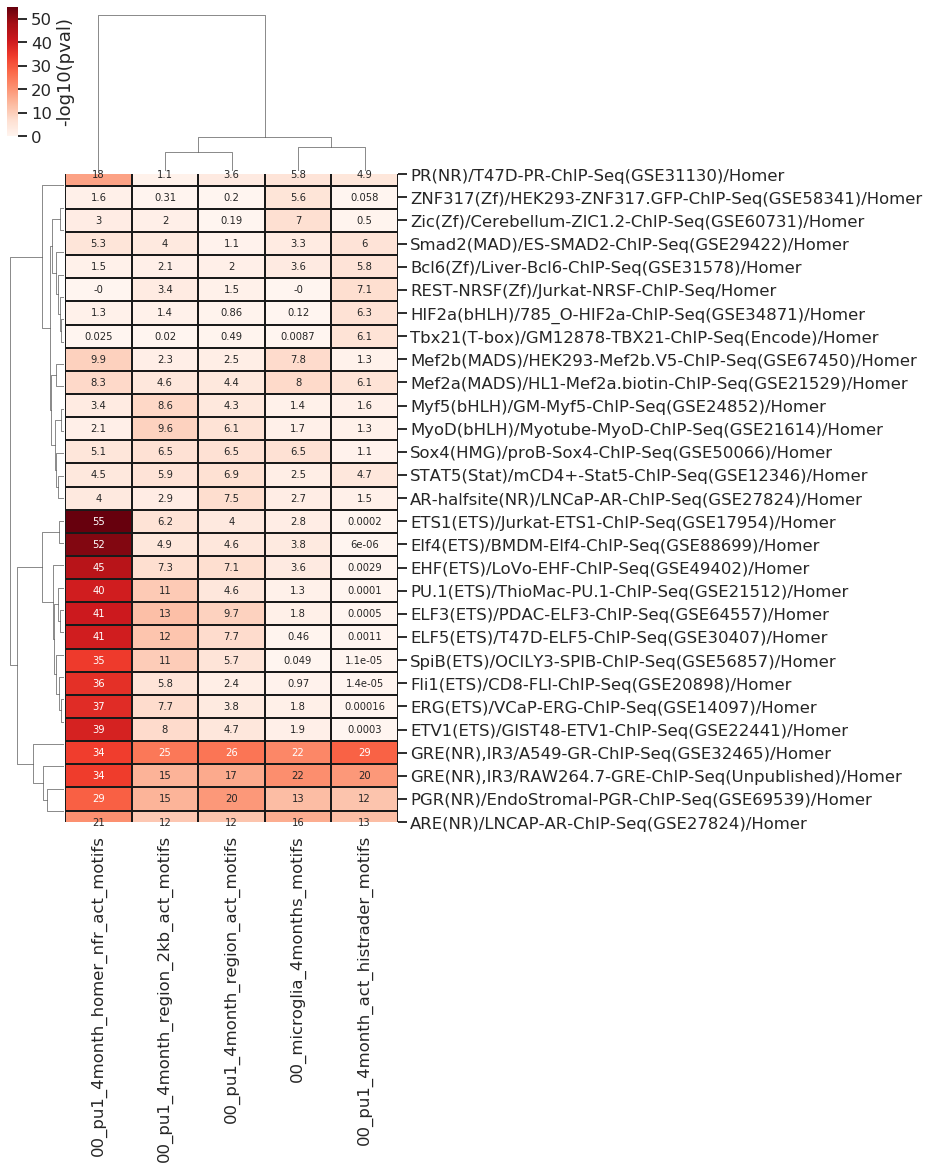

In [98]:
# set number of top motifs to grab
n_motifs = 10

temp = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('00_')]
temp = temp.loc[:, ~temp.columns.str.contains('nobg')]

# grab top motifs for each comparison
motifs = []
for col in temp.columns:
    motifs.extend(temp.sort_values(col, ascending=True).index.tolist()[:n_motifs])

sns.clustermap(
    -temp.loc[set(motifs), :],
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    figsize=(7,15))

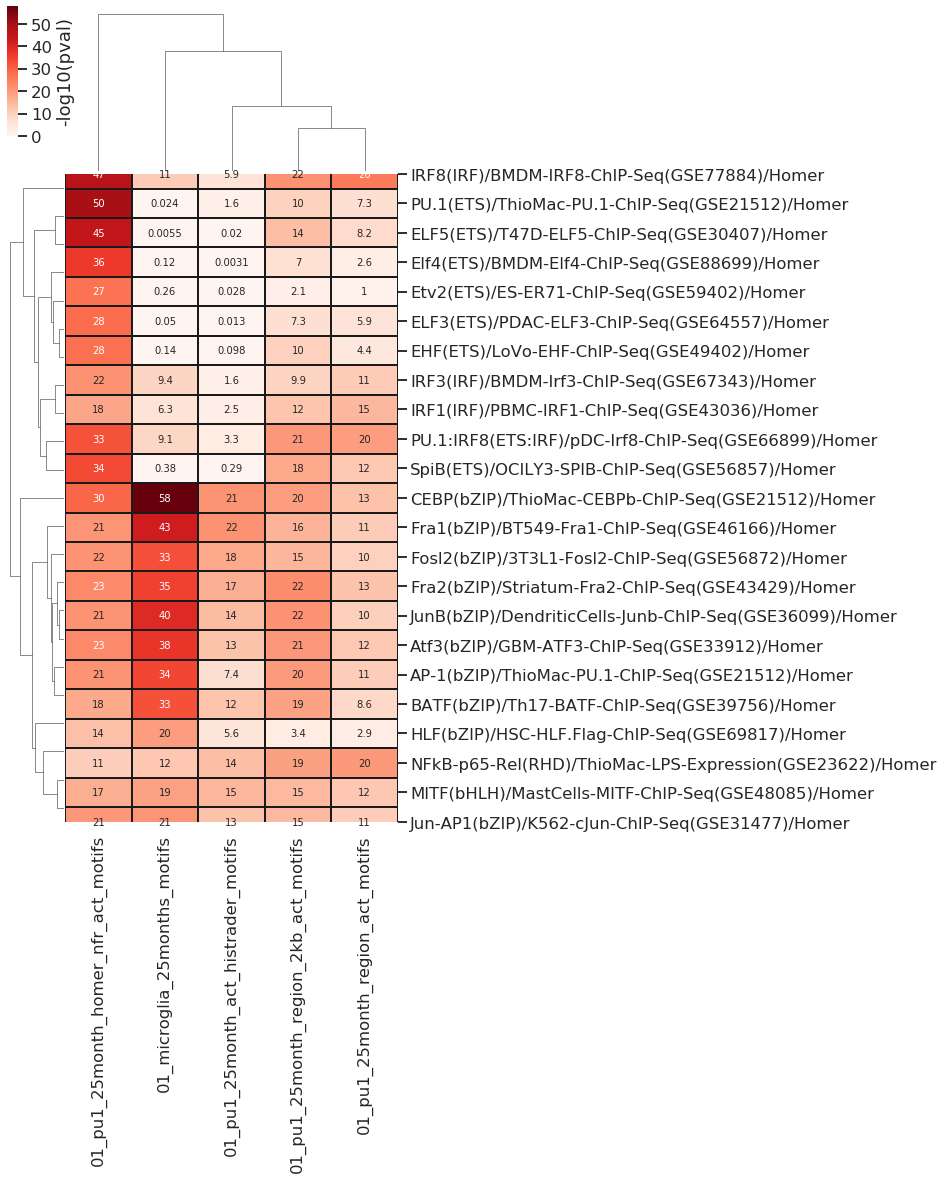

In [99]:
# set number of top motifs to grab
n_motifs = 10

temp = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('01_')]
temp = temp.loc[:, ~temp.columns.str.contains('nobg')]

# grab top motifs for each comparison
motifs = []
for col in temp.columns:
    motifs.extend(temp.sort_values(col, ascending=True).index.tolist()[:n_motifs])

sns.clustermap(
    -temp.loc[set(motifs), :],
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    figsize=(7,15))

# Now lets take a look at quantified correlation for known motif analysis

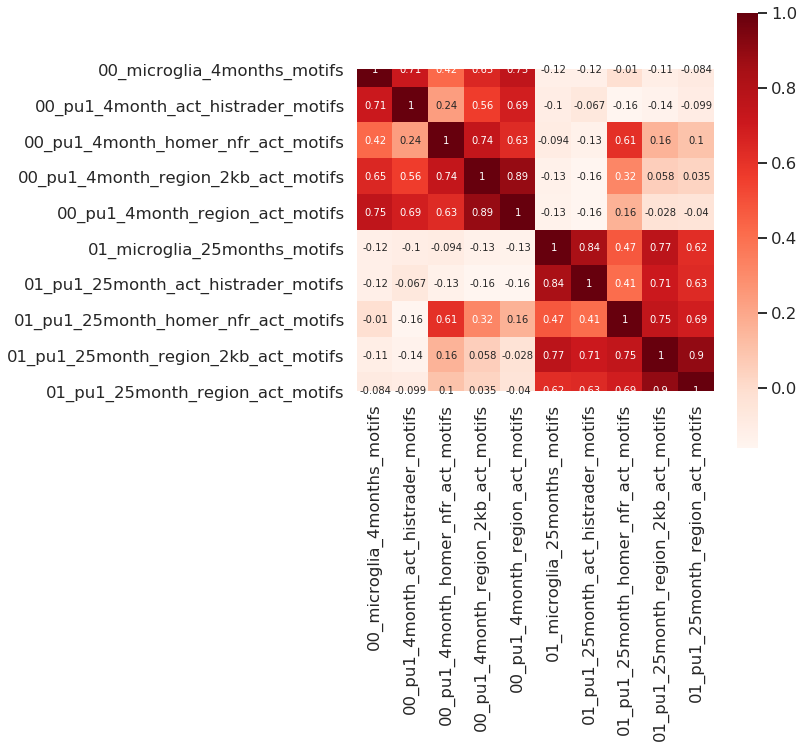

In [104]:
temp = known_motif_pval_frame.loc[:, ~known_motif_pval_frame.columns.str.contains('nobg')]

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(temp.corr(),
            cmap='Reds',
            annot=True,
            square=True,
            ax=ax)

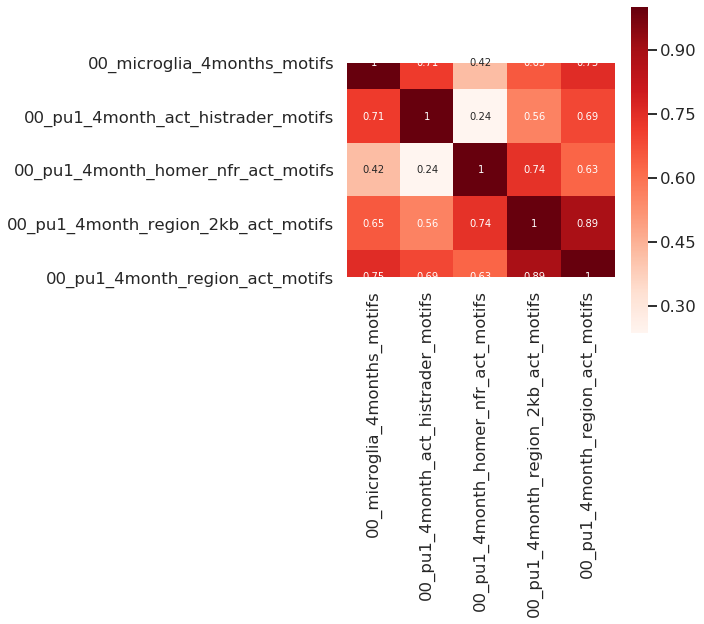

In [100]:
temp = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('00_')]
temp = temp.loc[:, ~temp.columns.str.contains('nobg')]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(temp.corr(),
            cmap='Reds',
            annot=True,
            square=True,
            ax=ax)

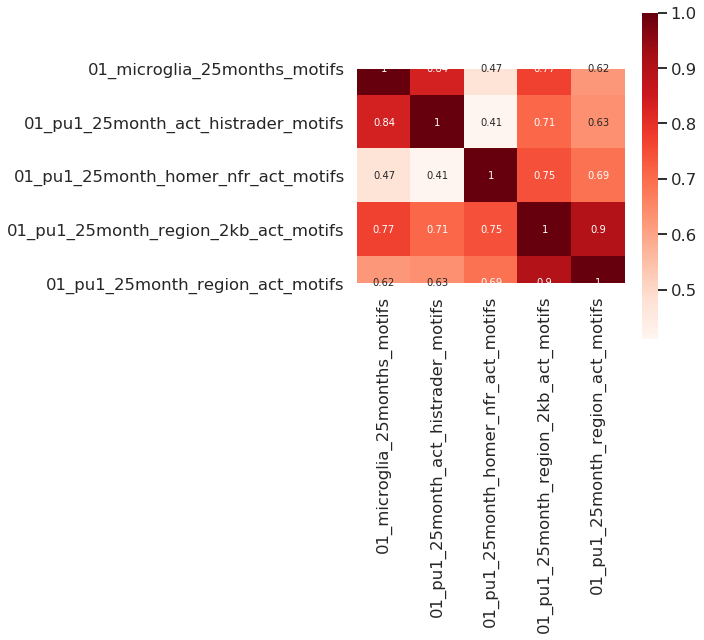

In [101]:
temp = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('01_')]
temp = temp.loc[:, ~temp.columns.str.contains('nobg')]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(temp.corr(),
            cmap='Reds',
            annot=True,
            square=True,
            ax=ax)